# **E-Commerce Analytics Notebook:**

# Load the Dataset

Goal: Import all necessary datasets (sales, products, customers, etc.) and explore the structure.

In [16]:
# Load datasets
orders = pd.read_csv("olist_orders_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

# Quick overview
print("Orders columns:", orders.columns)
print("Order items columns:", order_items.columns)
print("Products columns:", products.columns)


Orders columns: Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
Order items columns: Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Products columns: Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')


# Data Cleaning & Preprocessing

Goal: Handle missing values, convert data types, merge datasets for a unified view.

In [17]:
# Convert date columns
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Ensure numeric columns
order_items['price'] = pd.to_numeric(order_items['price'], errors='coerce')
order_items = order_items.dropna(subset=['price'])

# Merge datasets
full_data = order_items.merge(orders, on='order_id', how='left') \
                       .merge(customers, on='customer_id', how='left') \
                       .merge(products, on='product_id', how='left') \
                       .merge(sellers, on='seller_id', how='left') \
                       .merge(reviews[['order_id','review_score']], on='order_id', how='left')

# Revenue calculation
full_data['revenue'] = full_data['price']

# Extract month for trend analysis
full_data['order_month'] = full_data['order_purchase_timestamp'].dt.to_period('M').astype(str)


# Exploratory Data Analysis (EDA)

Goal: Understand sales trends, customer behavior, product performance.

**Monthly Sales & Revenue Trend**

1- Make sure numeric columns are correct.

2- Create a revenue column.

3- Aggregate revenue by month and plot.

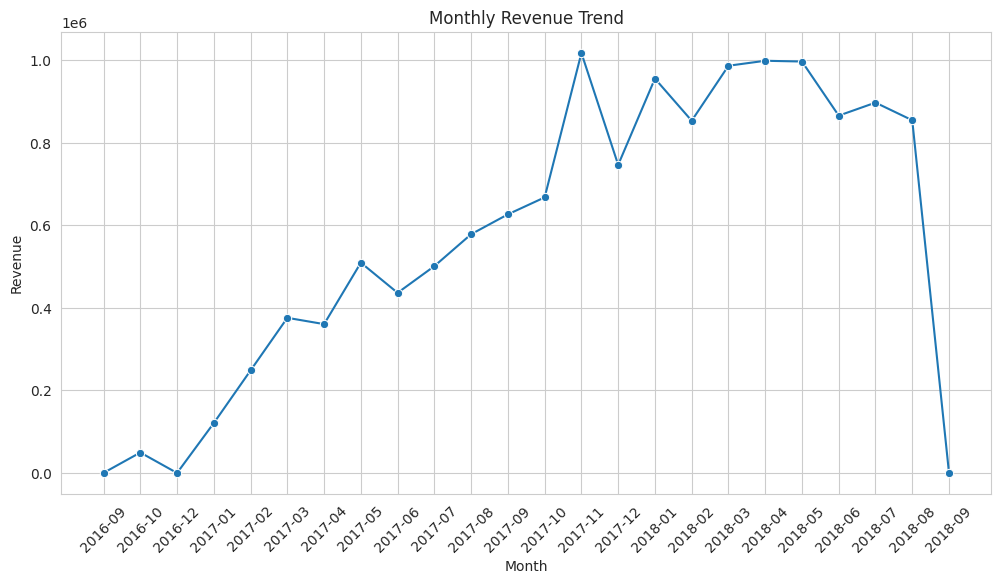

In [18]:
monthly_revenue = full_data.groupby('order_month')['revenue'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='order_month', y='revenue', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


**Top Products by Revenue**

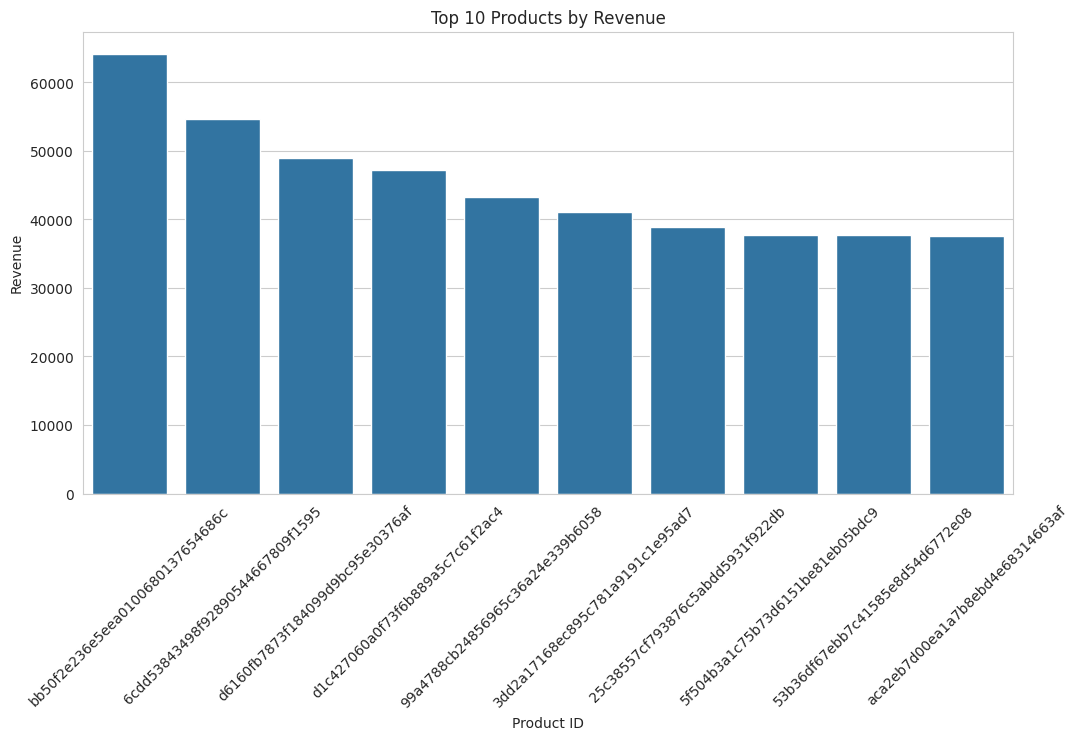

In [19]:
top_products = full_data.groupby('product_id')['revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.xticks(rotation=45)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Product ID")
plt.ylabel("Revenue")
plt.show()



**Customer Segmentation (High/Medium/Low)**

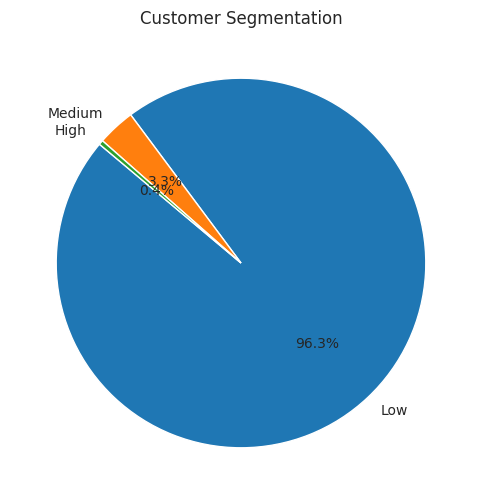

In [20]:
customer_revenue = full_data.groupby('customer_id')['revenue'].sum().reset_index()
bins = [0, 500, 1500, customer_revenue['revenue'].max()]
labels = ['Low', 'Medium', 'High']
customer_revenue['segment'] = pd.cut(customer_revenue['revenue'], bins=bins, labels=labels)

segment_counts = customer_revenue['segment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Customer Segmentation")
plt.show()



**Revenue by Region**

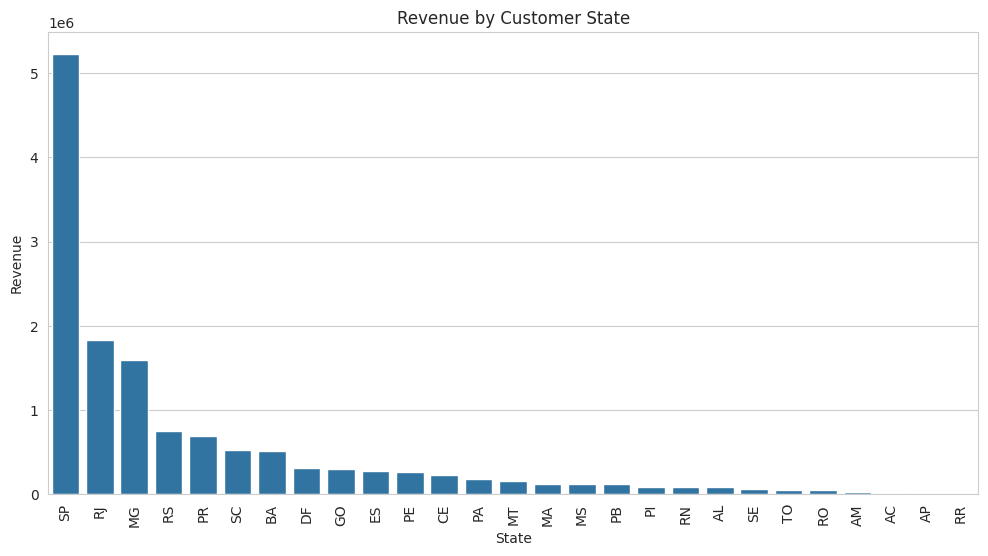

In [21]:
region_sales = full_data.groupby('customer_state')['revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=region_sales.index, y=region_sales.values)
plt.xticks(rotation=90)
plt.title("Revenue by Customer State")
plt.xlabel("State")
plt.ylabel("Revenue")
plt.show()


**Review Score Analysis**

In [23]:
avg_review = full_data.groupby('product_id')['review_score'].mean().sort_values(ascending=False).head(10)
print("Top 10 Products by Average Review Score:")
print(avg_review)



Top 10 Products by Average Review Score:
product_id
000b8f95fcb9e0096488278317764d19    5.0
fffdb2d0ec8d6a61f0a0a0db3f25b441    5.0
ffe9468f4d890db80b7231e86931ff37    5.0
ffeb228c521d5464d1f71444da96c446    5.0
8aebbc3445bef4a356ae41d226a7b5da    5.0
8aeef27d525d6bfa3b48e599a6c15ffd    5.0
8af2faad4d636a6f4f1d465cda23268f    5.0
8af4a717d0442a5fbe332dc587583296    5.0
8af78635010ca0b1366e5a2b17f52b59    5.0
8af8282e0fc19e99f70830c67f51b415    5.0
Name: review_score, dtype: float64


# Actionable Business Insights

Here, we turn EDA results into business decisions. The key is to identify patterns in revenue, products, customers, regions, and reviews.

**Top-performing Products**

In [10]:
top_products = full_data.groupby('product_id')['revenue'].sum().sort_values(ascending=False).head(10)
print("Top 10 Revenue-Generating Products:")
print(top_products)


Top 10 Revenue-Generating Products:
product_id
bb50f2e236e5eea0100680137654686c    63885.00
6cdd53843498f92890544667809f1595    54730.20
d6160fb7873f184099d9bc95e30376af    48899.34
d1c427060a0f73f6b889a5c7c61f2ac4    47214.51
99a4788cb24856965c36a24e339b6058    43025.56
3dd2a17168ec895c781a9191c1e95ad7    41082.60
25c38557cf793876c5abdd5931f922db    38907.32
5f504b3a1c75b73d6151be81eb05bdc9    37733.90
53b36df67ebb7c41585e8d54d6772e08    37683.42
aca2eb7d00ea1a7b8ebd4e68314663af    37608.90
Name: revenue, dtype: float64


**High-Value Customer Segments**

In [11]:
customer_revenue = full_data.groupby('customer_id')['revenue'].sum().reset_index()
bins = [0, 500, 1500, customer_revenue['revenue'].max()]
labels = ['Low', 'Medium', 'High']
customer_revenue['segment'] = pd.cut(customer_revenue['revenue'], bins=bins, labels=labels)

high_value_customers = customer_revenue[customer_revenue['segment']=='High']
print(f"High-Value Customers Count: {len(high_value_customers)}")


High-Value Customers Count: 385


**Regional Revenue Distribution**

In [12]:
region_sales = full_data.groupby('customer_state')['revenue'].sum().sort_values(ascending=False)
print(region_sales.head(10))


customer_state
SP    5202955.05
RJ    1824092.67
MG    1585308.03
RS     750304.02
PR     683083.76
SC     520553.34
BA     511349.99
DF     302603.94
GO     294591.95
ES     275037.31
Name: revenue, dtype: float64


**Review Score Patterns**

In [13]:
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
full_data_reviews = full_data.merge(reviews[['order_id','review_score']], on='order_id', how='left')

avg_review = full_data_reviews.groupby('product_id')['review_score'].mean().sort_values(ascending=False).head(10)
print(avg_review)


product_id
000b8f95fcb9e0096488278317764d19    5.0
fffdb2d0ec8d6a61f0a0a0db3f25b441    5.0
ffe9468f4d890db80b7231e86931ff37    5.0
ffeb228c521d5464d1f71444da96c446    5.0
8aebbc3445bef4a356ae41d226a7b5da    5.0
8aeef27d525d6bfa3b48e599a6c15ffd    5.0
8af2faad4d636a6f4f1d465cda23268f    5.0
8af4a717d0442a5fbe332dc587583296    5.0
8af78635010ca0b1366e5a2b17f52b59    5.0
8af8282e0fc19e99f70830c67f51b415    5.0
Name: review_score, dtype: float64


**Seasonal/Monthly Trends**

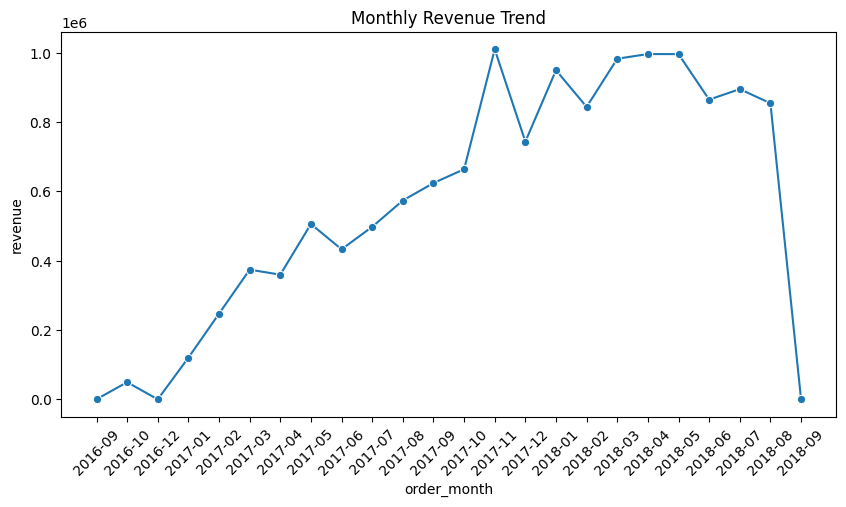

In [14]:
full_data['order_month'] = full_data['order_purchase_timestamp'].dt.to_period('M').astype(str)
monthly_revenue = full_data.groupby('order_month')['revenue'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_revenue, x='order_month', y='revenue', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.show()


In [24]:
summary = {
    "Total Revenue": full_data['revenue'].sum(),
    "Top Product by Revenue": top_products.index[0],
    "High-Value Customers": len(customer_revenue[customer_revenue['segment']=='High']),
    "Top Region by Revenue": region_sales.index[0],
    "Peak Revenue Month": monthly_revenue.loc[monthly_revenue['revenue'].idxmax(), 'order_month']
}

print("=== Executive Summary ===")
for k,v in summary.items():
    print(f"{k}: {v}")


=== Executive Summary ===
Total Revenue: 13651923.47
Top Product by Revenue: bb50f2e236e5eea0100680137654686c
High-Value Customers: 388
Top Region by Revenue: SP
Peak Revenue Month: 2017-11
